# PREDICTING CRIME IN CHICAGO

#### Importing the necessary Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import re
import string
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

## 1. Loading the dataset

In [2]:
path = ('./Crimes.csv')

In [3]:
crime = pd.read_csv(path)

In [4]:
crime.shape

> #### 1.1 Looking at the columns of the dataset

In [19]:
crime.columns()

> #### 1.2 Looking at the Top 5 observations 

In [6]:
crime.head()

> #### 1.3 Dropping the duplicates

In [7]:
crime.drop_duplicates(subset=['Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards', 'Boundaries - ZIP Codes',
       'Police Districts', 'Police Beats'], keep='first', inplace= True)

In [8]:
crime.shape

> ## 2. Data Dictionary

--------------------

1. **ID** - Unique identifier for the record. 

2. **Case Number** - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.

3. **Date** - Date when the incident occurred. this is sometimes a best estimate.

4. **Block** - The partially redacted address where the incident occurred, placing it on the same block as the actual address.

5. **IUCR** - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description.

6. **Primary Type** - The primary description of the IUCR code.

7. **Description** - The secondary description of the IUCR code, a subcategory of the primary description.

8. **Location Description** - Description of the location where the incident occurred.

9. **Arrest** - Indicates whether an arrest was made.

10. **Domestic** - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.

11. **Beat** - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts.  

12. **District** - Indicates the police district where the incident occurred. 

13. **Ward** - The ward (City Council district) where the incident occurred. 

14. **Community Area** - Indicates the community area where the incident occurred. Chicago has 77 community areas.

15. **FBI Code** - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). 

16. **X Coordinate** - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

17. **Y Coordinate** - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

18. **Year** - Year the incident occurred.

19. **Updated On** - Date and time the record was last updated.

20. **Latitude** - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

21. **Longitude** - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

22. **Location** - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

---------

## 3. Data Cleaning

> #### 3.1 Selecting necessary Columns

In [9]:
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 100)
crime.head(2)

In [10]:
crimes = crime.loc[:,['Date',
                      'Block',
                      'IUCR',
                      'Primary Type',
                      'Description',
                      'Location Description',
                      'Arrest', 
                      'Domestic', 
                      'Police Beats',
                      'District', 
                      'Wards', 
                      'Community Areas', 
                      'FBI Code', 
                      'Year',
                      'Latitude',
                      'Longitude',
                     'Census Tracts']]

> #### 3.2 Renaming the columns

In [11]:
crimes.rename(columns={'Date':'datetime',
                       'Block':'address', 
                       'IUCR': 'IL_crime_code', 
                       'Primary Type':'crime_type',
                       'Description':'crime_description',
                       'Location Description':'location_description',
                       'Arrest':'arrests',
                       'Domestic':'domestic_violence',
                       'Police Beats': 'pbeats',
                       'District':'pdistricts',
                       'Wards': 'wards',
                       'Community Areas': 'community_areas',
                       'FBI Code': 'FBI_code',
                       'Year':'year', 
                       'Latitude':'latitude', 
                       'Longitude':'longitude',
                      'Census Tracts':'census_tracts'}, inplace= True)

In [20]:
columns=pd.DataFrame(crimes.columns)

In [17]:
columns

In [21]:
crimes.head(2)

In [14]:
crimes.shape

(1943346, 17)

> #### 3.3 Keeping every column in lower case

In [15]:
crimes['address']=crimes.address.str.lower()
crimes['crime_type']=crimes.crime_type.str.lower()
crimes['crime_description']=crimes.crime_description.str.lower()
crimes['location_description']=crimes.location_description.str.lower()

> #### 3.4 Checking the columns having null values

In [16]:
null = pd.DataFrame(crimes.isnull().sum(), columns=['total_null'])

In [17]:
null['null_%age'] = round((crimes.isnull().sum())/len(crimes),2)

In [18]:
null

,total_null,null_%age
datetime,1,0.00
address,1,0.00
IL_crime_code,1,0.00
crime_type,1,0.00
crime_description,1,0.00
location_description,4326,0.00
arrests,1,0.00
domestic_violence,1,0.00
pbeats,22116,0.01
pdistricts,2,0.00


It's just 0.01 percentage of the total data thats null, so will drop all the null values in the dataset

In [19]:
crimes.dropna(inplace=True)

In [20]:
crimes.shape

(1916264, 17)

> #### 3.5 Datatypes

In [21]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1916264 entries, 0 to 1946348
Data columns (total 17 columns):
datetime                object
address                 object
IL_crime_code           object
crime_type              object
crime_description       object
location_description    object
arrests                 object
domestic_violence       object
pbeats                  float64
pdistricts              float64
wards                   float64
community_areas         float64
FBI_code                object
year                    float64
latitude                float64
longitude               float64
census_tracts           float64
dtypes: float64(8), object(9)
memory usage: 263.2+ MB


> #### 3.6 Datatypes of the datetime is convereted to datatime 

In [22]:
%%time
crimes['datetime']= crimes['datetime'].astype('datetime64[ns]')

CPU times: user 3min 17s, sys: 373 ms, total: 3min 18s
Wall time: 3min 18s


> #### 3.7 Cleaning Location Desription 

In [23]:
def loc(text):
    text = text.replace('-',' ')
    text = text.replace('.',' ')
    text = text.replace('/',' ')
    text = text.replace('(',' ')
    text = text.replace(')',' ')
    text= text.strip()
    return text

In [24]:
crimes["location_description"]=crimes["location_description"].apply(lambda x: loc(x))

In [25]:
crimes["location_description"].replace('medical dental office','dental office',inplace= True)

crimes["location_description"].replace('airport terminal upper level   non secure area','airport terminal',inplace= True)

crimes["location_description"].replace('airport terminal lower level   secure area','airport terminal',inplace= True)

crimes["location_description"].replace('airport terminal mezzanine   non secure area','airport',inplace= True)

crimes["location_description"].replace('airport transportation system  ats','airport',inplace= True)

crimes["location_description"].replace('airport building non terminal   secure area','airport terminal',inplace= True)

crimes["location_description"].replace('airport building non terminal   non secure area','airport terminal',inplace= True)

crimes["location_description"].replace('airport terminal lower level   non secure area','airport terminal',inplace= True)

crimes["location_description"].replace('cha hallway','hallway',inplace= True)

crimes["location_description"].replace('stairwell','elevator',inplace= True)

crimes["location_description"].replace('gas station drive prop','gas station',inplace= True)

In [26]:
crimes["location_description"].replace('cha parking lot grounds','parking',inplace= True)

crimes["location_description"].replace('residential yard  front back','residential yard',inplace= True)

crimes["location_description"].replace('commercial   business office','office',inplace= True)

crimes["location_description"].replace('atm  automatic teller machine','atm',inplace= True)

crimes["location_description"].replace('college university grounds','university grounds',inplace= True)

crimes["location_description"].replace('other commercial transportation','commercial transportation',inplace= True)

crimes["location_description"].replace('police facility veh parking lot','parking',inplace= True)

crimes["location_description"].replace('school, public, building','school',inplace= True)

crimes["location_description"].replace('school, private, building','school',inplace= True)

crimes["location_description"].replace('cha hallway stairwell elevator','elevator',inplace= True)

In [27]:
crimes["location_description"].replace('cta bus','bus',inplace= True)

crimes["location_description"].replace('other railroad prop   train depot','train depot',inplace= True)

crimes["location_description"].replace('cta platform','platform',inplace= True)

crimes["location_description"].replace('residence porch hallway','residence porch',inplace= True)

crimes["location_description"].replace('bar or tavern','tavern',inplace= True)

In [28]:
crimes["location_description"].replace('cta station','train station',inplace= True)

crimes["location_description"].replace('school, private, grounds','school',inplace= True)

crimes["location_description"].replace('jail   lock up facility','lock up facility',inplace= True)

crimes["location_description"].replace('cta bus stop','bus stop',inplace= True)

crimes["location_description"].replace('cta "l" train','train depot',inplace= True)

crimes["location_description"].replace('cta bus stop','bus stop',inplace= True)

crimes["location_description"].replace('cta "l" train','train depot',inplace= True)

crimes["location_description"].replace('vehicle commercial','commercial vehicle',inplace= True)

crimes["location_description"].replace('other commercial transportation','commercial transportation',inplace= True)

crimes["location_description"].replace('vehicle   other ride share service  e g , uber, lyft','taxicab',inplace= True)

crimes["location_description"].replace('vehicle commercial   trolley bus','commercial vehicle',inplace= True)

crimes["location_description"].replace('other commercial transportation','commercial transportation',inplace= True)


In [29]:
crimes["location_description"].replace('barber shop beauty salonn','commercial transportation',inplace= True)

crimes["location_description"].replace('cha parking lot','parking',inplace= True)

crimes["location_description"].replace('other commercial transportation','commercial transportation',inplace= True)

crimes["location_description"].replace('vehicle commercial   entertainment party bus','party bus',inplace= True)

crimes["location_description"].replace('vehicle   other ride service','taxicab',inplace= True)

crimes["location_description"].replace('church synagogue place of worship','church',inplace= True)

crimes["location_description"].replace('college university residence hall','university residence hall',inplace= True)

crimes["location_description"].replace('vehicle   delivery truck','delivery truck',inplace= True)

crimes["location_description"].replace('school, public, grounds','school grounds',inplace= True)

crimes["location_description"].replace('airport terminal upper level   secure area','airport terminal',inplace= True)

crimes["location_description"].replace('cta "l" platform','platform',inplace= True)

crimes["location_description"].replace('barber shop beauty salon','barbershop',inplace= True)

crimes["location_description"].replace('factory manufacturing building','building',inplace= True)

crimes["location_description"].replace('parking lot','parking',inplace= True)
 
crimes["location_description"].replace('pool room','poolroom',inplace= True)

crimes["location_description"].replace('cta garage','garage',inplace= True)

crimes["location_description"].replace('parking lot','parking',inplace= True)

crimes["location_description"].replace('parking lot garage non resid','parking',inplace= True)


In [30]:
crimes["location_description"].replace('small retail store','store',inplace= True)

crimes["location_description"].replace('convenience store','store',inplace= True)

crimes["location_description"].replace('department store','store',inplace= True)

crimes["location_description"].replace('grocery food store','store',inplace= True)

In [31]:
crimes["location_description"].replace('garage/auto repair','garage',inplace= True)

crimes["location_description"].replace('cha apartment','apartment',inplace= True)

crimes["location_description"].replace('hotel motel','hotel',inplace= True)

crimes["location_description"].replace('cta "l" train','train depot',inplace= True)

crimes["location_description"].replace('sports arena stadium','sports stadium',inplace= True)

crimes["location_description"].replace('driveway   residential','residential driveway',inplace= True)

crimes["location_description"].replace('residence','residential property',inplace= True)

In [32]:
crimes["location_description"].replace('government building property','government building',inplace= True)

crimes["location_description"].replace('hospital building grounds','hospital building',inplace= True)

crimes["location_description"].replace('federal building','government building',inplace= True)

## 4. Feature Engineering

> #### 4.1 Extacting Features from the datetime column

In [33]:
crimes['month'] = crimes['datetime'].dt.month
crimes['day'] = crimes['datetime'].dt.day
crimes['hour'] = crimes['datetime'].dt.hour
crimes['minute'] = crimes['datetime'].dt.minute
crimes['weekofday']= crimes['datetime'].dt.dayofweek

In [34]:
Weekofday= {
    0:"monday",
    1:"tuesday",
    2:"wednesday",
    3:"thurshday",
    4:"friday",
    5:"saturday",
    6:"sunday"
    }

In [35]:
crimes['weekofday'] = crimes['weekofday'].map(Weekofday)

**Below shows crimes happening on every day and there isnt much difference between the week day or week end.**

In [36]:
crimes['weekofday'].value_counts(normalize=True)

friday       0.150571
saturday     0.145234
wednesday    0.141845
monday       0.141710
thurshday    0.141071
tuesday      0.140729
sunday       0.138841
Name: weekofday, dtype: float64

In [37]:
crimes.head(2)

,datetime,address,IL_crime_code,crime_type,crime_description,location_description,arrests,domestic_violence,pbeats,pdistricts,wards,community_areas,FBI_code,year,latitude,longitude,census_tracts,month,day,hour,minute,weekofday
0,2019-04-19 23:48:00,024xx w van buren st,051A,assault,aggravated: handgun,street,False,False,146.0,11.0,23.0,29.0,04A,2019.0,41.876072,-87.687615,756.0,4,19,23,48,friday
1,2019-04-19 23:45:00,042xx w 76th st,0320,robbery,strongarm - no weapon,other,False,False,209.0,8.0,30.0,63.0,03,2019.0,41.755028,-87.728551,318.0,4,19,23,45,friday


> #### 4.2 Added 77 community Area

In [38]:
# Creating list of Area name with Community Area code.
areas = {
    "1": "Rogers Park Chicago",
    "2": "West Ridge Chicago",
    "3": "Up-town Chicago",
    "4": "Lincoln Square Chicago",
    "5": "North Center Chicago",
    "6": "Lakeview Chicago",
    "7": "Lincoln Park Chicago",
    "8": "Near North Side Chicago",
    "9": "Edison Park Chicago",
    "10": "Norwood Park Chicago",
    "11": "Jefferson Park Chicago",
    "12": "Forest Glen Chicago",
    "13": "North Park Chicago",
    "14": "Albany Park Chicago",
    "15": "Portage Park Chicago",
    "16": "Irving Park Chicago",
    "17": "Dunning Chicago",
    "18": "Montclare Chicago",
    "19": "Belmont Cragin Chicago",
    "20": "Hermosa Chicago",
    "21": "Avondale Chicago",
    "22": "Logan Square Chicago",
    "23": "Humboldt Park Chicago",
    "24": "West Town Chicago",
    "25": "Austin Chicago",
    "26": "West Garfield Park Chicago",
    "27": "East Garfield Park Chicago",
    "28": "Near West Side Chicago",
    "29": "North Lawndale Chicago",
    "30": "South Lawndale Chicago",
    "31": "Lower West Side Chicago",
    "32": "The Loop Chicago",
    "33": "Near South Side Chicago",
    "34": "Armour Square Chicago",
    "35": "Douglas Chicago",
    "36": "Oakland Chicago",
    "37": "Fuller Park Chicago",
    "38": "Grand Boulevard Chicago",
    "39": "Kenwood Chicago",
    "40": "Washington Park Chicago",
    "41": "Hyde Park Chicago",
    "42": "Woodlawn Chicago",
    "43": "South Shore Chicago",
    "44": "Chatham Chicago",
    "45": "Avalon Park Chicago",
    "46": "South Chicago",
    "47": "Burnside Chicago",
    "48": "Calumet Heights Chicago",
    "49": "Roseland Chicago",
    "50": "Pullman Chicago",
    "51": "South Deering Chicago",
    "52": "East Side Chicago",
    "53": "West Pullman Chicago",
    "54": "Riverdale Chicago",
    "55": "Hegewisch Chicago",
    "56": "Garfield Ridge Chicago",
    "57": "Archer Heights Chicago",
    "58": "Brighton Park Chicago",
    "59": "McKinley Park Chicago",
    "60": "Bridgeport Chicago",
    "61": "New City Chicago",
    "62": "West Elsdon Chicago",
    "63": "Gage Park Chicago",
    "64": "Clearing Chicago",
    "65": "West Lawn Chicago",
    "66": "Chicago Lawn Chicago",
    "67": "West Englewood Chicago",
    "68": "Englewood Chicago",
    "69": "Greater Grand Crossing Chicago",
    "70": "Ashburn Chicago",
    "71": "Auburn Gresham Chicago",
    "72": "Beverly Chicago",
    "73": "Washington Heights Chicago",
    "74": "Mount Greenwood Chicago",
    "75": "Morgan Park Chicago",
    "76": "O'Hare Chicago",
    "77": "Edgewater Chicago"
}

In [39]:
crimes['community_areas'] = crimes['community_areas'].astype(float)
crimes['community_areas'] = crimes['community_areas'].astype(int)
crimes['community_areas'] = crimes['community_areas'].astype(str)
crimes['community_area_name'] = crimes['community_areas'].map(areas)

> #### 4.3 Adding police Districts

In [40]:
police_district ={
    "1":"Central",
    "2":"Wentworth",
    "3":"Grand Crossing",
    "4":"South Chicago",
    "5":"Calumet",
    "6":"Gresham",
    "7":"Englewood",
    "8":"Chicago Lawn",
    "9":"Deering",
    "10":"Ogden",
    "11":"Harrison",
    "12":"Near West",
    "15":"Shakespeare",
    "14":"Austin",
    "16":"Jefferson Park",
    "17":"Albany Park",
    "18":"Near North",
    "19":"Town Hall",
    "20":"Lincoln",
    "22":"Morgan Park",
    "24":"Rogers Park",
    "25":"Grand Central"    }
         

Looking at the data I got 23 distinct police districts in chicago, but after study realised there are just 22 police district and **31** is not a valid police district.

In [41]:
crimes['pdistricts'].value_counts().sort_values()

31.0        13
20.0     31951
24.0     53103
17.0     54650
22.0     61420
16.0     64229
14.0     68952
15.0     80560
2.0      80852
5.0      85584
19.0     87013
10.0     88834
9.0      89919
1.0      91471
12.0     92816
18.0     93005
3.0      94573
25.0    105177
7.0     107512
4.0     110184
6.0     116020
8.0     122983
11.0    135443
Name: pdistricts, dtype: int64

#### From study I know chicago have 22 Police Districts

In [42]:
unvalid_pd = crimes[crimes['pdistricts']== 31.0]

In [43]:
for index in unvalid_pd.index:
    crimes = crimes.drop(index)

In [44]:
crimes['pdistricts'] = crimes['pdistricts'].astype(float)
crimes['pdistricts'] = crimes['pdistricts'].astype(int)
crimes['pdistricts'] = crimes['pdistricts'].astype(str)
crimes['pdistricts_name'] = crimes['pdistricts'].map(police_district)

In [45]:
crimes.head(2)

,datetime,address,IL_crime_code,crime_type,crime_description,location_description,arrests,domestic_violence,pbeats,pdistricts,wards,community_areas,FBI_code,year,latitude,longitude,census_tracts,month,day,hour,minute,weekofday,community_area_name,pdistricts_name
0,2019-04-19 23:48:00,024xx w van buren st,051A,assault,aggravated: handgun,street,False,False,146.0,11,23.0,29,04A,2019.0,41.876072,-87.687615,756.0,4,19,23,48,friday,North Lawndale Chicago,Harrison
1,2019-04-19 23:45:00,042xx w 76th st,0320,robbery,strongarm - no weapon,other,False,False,209.0,8,30.0,63,03,2019.0,41.755028,-87.728551,318.0,4,19,23,45,friday,Gage Park Chicago,Chicago Lawn


> #### 4.4 Nine Districts in Chicago

In [46]:
# 9 Districts in Chicago

nine_districts={
    "Far North Side": ["Rogers Park Chicago",
                      "West Ridge Chicago",
                      "Up-town Chicago",
                      "Lincoln Square Chicago",
                      "Edison Park Chicago" ,
                      "Norwood Park Chicago",
                      "Jefferson Park Chicago",
                      "Forest Glen Chicago",
                      "North Park Chicago",
                      "Albany Park Chicago",
                      "O'Hare Chicago" ,
                      "Edgewater Chicago" ],
    
     "North Side":    ["North Center Chicago",
                       "Lakeview Chicago",
                       "Lincoln Park Chicago",
                       "Avondale Chicago",
                       "Logan Square Chicago"] ,
    
    "Northwest Side": ["Portage Park Chicago",
                       "Irving Park Chicago",
                       "Dunning Chicago",
                       "Montclare Chicago",
                       "Belmont Cragin Chicago",
                       "Hermosa Chicago"],
    
     "Central":       ["Near North Side Chicago",
                       "The Loop Chicago",
                       "Near South Side Chicago"],
    
    "West Side":      ["Humboldt Park Chicago",
                       "West Town Chicago",
                       "Austin Chicago",
                       "West Garfield Park Chicago",
                       "East Garfield Park Chicago",
                       "Near West Side Chicago",
                       "North Lawndale Chicago",
                       "South Lawndale Chicago" ,
                       "Lower West Side Chicago" ],
    
    "Southwest Side":  ["Garfield Ridge Chicago",
                        "Archer Heights Chicago ",
                        "Brighton Park Chicago",
                        "McKinley Park Chicago",
                        "New City Chicago",
                        "West Elsdon Chicago",
                        "Gage Park Chicago",
                        "Clearing Chicago",
                        "West Lawn Chicago",
                        "Chicago Lawn Chicago",
                        "West Englewood Chicago",
                        "Englewood Chicago"],
    
    "South Side":      ["Armour Square Chicago",
                        "Douglas Chicago",
                        "Oakland Chicago",
                        "Fuller Park Chicago",
                        "Grand Boulevard Chicago",
                        "Kenwood Chicago",
                        "Washington Park Chicago",
                        "Hyde Park Chicago",
                        "Woodlawn Chicago",
                        "South Shore Chicago",
                        "Bridgeport Chicago",
                        "Greater Grand Crossing Chicago" ],
    
    "Far Southwest Side": ["Ashburn Chicago",
                           "Auburn Gresham Chicago",
                           "Beverly Chicago",
                           "Washington Heights Chicago",
                           "Mount Greenwood Chicago",
                           "Morgan Park Chicago"],
    
    "Far South Side":    ["Chatham Chicago",
                          "Avalon Park Chicago",
                          "South Chicago Chicago",
                          "Burnside Chicago",
                          "Calumet Heights Chicago",
                          "Roseland Chicago",
                          "Pullman Chicago",
                          "South Deering Chicago",
                          "East Side Chicago",
                          "West Pullman Chicago",
                          "Riverdale Chicago",
                          "Hegewisch Chicago "]
                }

In [47]:
df=pd.DataFrame(columns=["area","district"])
for key,value in nine_districts.items():
#     print(key,value)
    for x in value:
        df=df.append({"area":x,"district":key},ignore_index= True)
    

In [48]:
crimes=crimes.merge(df,how="inner",left_on="community_area_name",right_on="area")

In [49]:
crimes.drop(['area'],axis=1,inplace=True)

In [50]:
crimes['district'].value_counts()

West Side             499211
South Side            341163
Southwest Side        315785
Far North Side        162657
Far South Side        156148
Northwest Side        119360
Far Southwest Side    116621
North Side             71318
Central                63291
Name: district, dtype: int64

> #### 4.5 Fixing the crime type and looking at the percentage of all crimes happening.

In [51]:
crimes['crime_type'].replace('non - criminal','non-criminal',inplace=True)
crimes['crime_type'].replace('non-criminal (subject specified)','non-criminal',inplace=True)
crimes['crime_type'].replace('other offense','general offense',inplace=True)

In [52]:
crimes['crime_type'] = pd.Categorical(crimes['crime_type'])
crime_count= pd.DataFrame(crimes.groupby(['crime_type']).size().sort_values(ascending= False),columns= ['crime_counts'])

In [53]:
crime_count['total_crime_%age']= crime_count['crime_counts']/(np.sum(crime_count['crime_counts']))

In [54]:
crime_count.tail(16)

,crime_counts,total_crime_%age
crime_type,,
interference with public officer,8326,0.004511
prostitution,8010,0.004340
sex offense,6339,0.003435
homicide,3726,0.002019
arson,2836,0.001537
gambling,2470,0.001338
liquor law violation,2038,0.001104
kidnapping,1378,0.000747
stalking,1144,0.000620


**Creating Buckets from Crime type to Crime Classification**

In [55]:
crimes.loc[crimes['crime_type'].isin(["crim sexual assault",
                                      "prostitution",
                                      "sex offense",]),"crime_classification"]= "sexual_offenses"

crimes.loc[crimes['crime_type'].isin(["narcotics",
                                      "other narcotic violation"]), 'crime_classification'] = "drug_offenses"


crimes.loc[crimes['crime_type'].isin(["concealed carry license violation",
                                      "weapons violation"]), 'crime_classification'] = "iillegal_weapon_offenses"


crimes.loc[crimes['crime_type'].isin(["liquor law violation",
                                      "non-criminal",
                                      "general offense"]), 'crime_classification'] = "general_offenses"

crimes.loc[crimes['crime_type'].isin(["gambling",
                                      "interference with public officer",
                                      "intimidation",
                                      "obscenity",
                                      "public peace violation",
                                      "public indecency",
                                      "stalking"]), 'crime_classification'] = "public_indecency"



crimes.loc[crimes['crime_type'].isin(["motor vehicle theft",
                                      "theft",
                                      "burglary",
                                      "robbery",
                                      "deceptive practice"]), 'crime_classification'] = "theft"


crimes.loc[crimes['crime_type'].isin(["assault",
                                      "battery"]), 'crime_classification'] = "violent_offenses"

crimes.loc[crimes['crime_type'].isin(["kidnapping",
                                      "human trafficking"]), 'crime_classification'] = "kidnapping"

# criminal damange -> Delibarate damage to vehical or property.
# arson-> setting someones property to fire.
# criminal--> tresspassing to someones property
crimes.loc[crimes['crime_type'].isin(["criminal damage",
                                      "criminal trespass",
                                      "arson"]), 'crime_classification'] = "criminal_damage"

crimes.loc[crimes['crime_type'].isin(["offense involving children"]), 'crime_classification'] = "child_abuse"

crimes.loc[crimes['crime_type'].isin(["homicide"]), 'crime_classification'] = "homicide"

#crimes

In [56]:
crimes.isnull().sum()

datetime                0
address                 0
IL_crime_code           0
crime_type              0
crime_description       0
location_description    0
arrests                 0
domestic_violence       0
pbeats                  0
pdistricts              0
wards                   0
community_areas         0
FBI_code                0
year                    0
latitude                0
longitude               0
census_tracts           0
month                   0
day                     0
hour                    0
minute                  0
weekofday               0
community_area_name     0
pdistricts_name         0
district                0
crime_classification    0
dtype: int64

> #### 4.6 Converting the month in season

In [57]:
def weather(data):
    if (data == 1) | (data == 2) |(data == 12):
        data='winter'
    if (data == 3) | (data == 4) | (data == 5):
        data='spring'
    if (data == 6) | (data == 7) | (data == 8):
        data='summer'
    if (data == 9) | (data == 10) | (data == 11):
        data='autumn'
    return data

In [58]:
crimes['season'] = crimes['month'].map(lambda x: weather(x))

> #### 4.7 Converting the hour into time of day

In [59]:
def day_time(data):
    if (data == 3) | (data == 4) |(data == 5)|(data == 6)|(data == 7):
        data='early morning'
    if (data == 8) | (data == 9) | (data == 10) | (data == 11)|(data == 12):
        data='late morning'
    if (data == 13) | (data == 14) | (data == 15)|(data == 16)|(data == 17):
        data='afternoon'
    if (data == 18) | (data == 19) | (data == 20)|(data == 21):
        data='evening'
    if (data == 22) | (data == 23) |(data == 0) | (data == 1) | (data == 2):
        data='night'
    return data

In [60]:
crimes['parts_of_day'] = crimes['hour'].map(lambda x: day_time(x))

In [61]:
crimes.head(3).T

,0,1,2
datetime,2019-04-19 23:48:00,2019-04-19 23:19:00,2019-04-19 23:15:00
address,024xx w van buren st,025xx w washington blvd,002xx s hoyne ave
IL_crime_code,051A,0910,2820
crime_type,assault,motor vehicle theft,general offense
crime_description,aggravated: handgun,automobile,telephone threat
location_description,street,residential driveway,apartment
arrests,False,False,False
domestic_violence,False,False,True
pbeats,146,77,139
pdistricts,11,12,12


In [62]:
crimes.isnull().sum()

datetime                0
address                 0
IL_crime_code           0
crime_type              0
crime_description       0
location_description    0
arrests                 0
domestic_violence       0
pbeats                  0
pdistricts              0
wards                   0
community_areas         0
FBI_code                0
year                    0
latitude                0
longitude               0
census_tracts           0
month                   0
day                     0
hour                    0
minute                  0
weekofday               0
community_area_name     0
pdistricts_name         0
district                0
crime_classification    0
season                  0
parts_of_day            0
dtype: int64

In [63]:
crimes[crimes.index == 0]

,datetime,address,IL_crime_code,crime_type,crime_description,location_description,arrests,domestic_violence,pbeats,pdistricts,wards,community_areas,FBI_code,year,latitude,longitude,census_tracts,month,day,hour,minute,weekofday,community_area_name,pdistricts_name,district,crime_classification,season,parts_of_day
0,2019-04-19 23:48:00,024xx w van buren st,051A,assault,aggravated: handgun,street,False,False,146.0,11,23.0,29,04A,2019.0,41.876072,-87.687615,756.0,4,19,23,48,friday,North Lawndale Chicago,Harrison,West Side,violent_offenses,spring,night


## Analysing the features

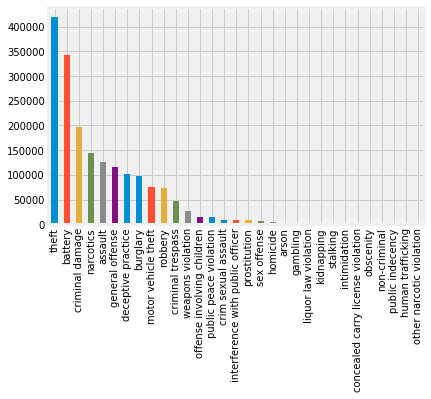

In [64]:
#Plotting the features:
crimes['crime_type'].value_counts().plot(kind='bar',)


THEFT is the most recorded crime.

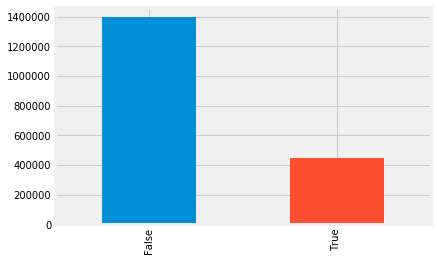

In [65]:
crimes['arrests'].value_counts().plot(kind='bar')

Not many arrests compared the crime recorded.

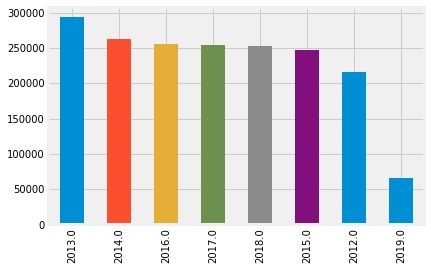

In [66]:
crimes['year'].value_counts().plot(kind='bar')

The crime rate has reduced over the years. It was highest in 2013. Since 2014, the crime rate has reduced.

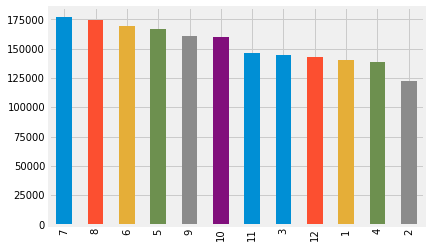

In [67]:
crimes['month'].value_counts().plot(kind='bar')

The Crime is higher between May and August compared to the rest of the year.However, the crime rate is lower during the winter months, February has he lowest crime rate registered.

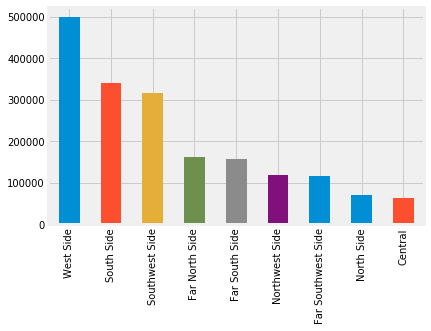

In [68]:
crimes['district'].value_counts().plot(kind='bar')

In [69]:
crimes.shape

(1845554, 28)

In [70]:
crimes.head(2)

,datetime,address,IL_crime_code,crime_type,crime_description,location_description,arrests,domestic_violence,pbeats,pdistricts,wards,community_areas,FBI_code,year,latitude,longitude,census_tracts,month,day,hour,minute,weekofday,community_area_name,pdistricts_name,district,crime_classification,season,parts_of_day
0,2019-04-19 23:48:00,024xx w van buren st,051A,assault,aggravated: handgun,street,False,False,146.0,11,23.0,29,04A,2019.0,41.876072,-87.687615,756.0,4,19,23,48,friday,North Lawndale Chicago,Harrison,West Side,violent_offenses,spring,night
1,2019-04-19 23:19:00,025xx w washington blvd,0910,motor vehicle theft,automobile,residential driveway,False,False,77.0,12,46.0,29,07,2019.0,41.882972,-87.689778,37.0,4,19,23,19,friday,North Lawndale Chicago,Near West,West Side,theft,spring,night


In [71]:
crimes.to_csv("crime_data_2.csv")